# Clustering  // ADAM GREENAN 21306729 // ROY 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import manifold #needed for multidimensional scaling (MDS) and t-SNE
from sklearn import cluster #needed for k-Means clustering
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, FunctionTransformer #needed for data preparation

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn import set_config

Load dataset tracks

In [3]:
df = pd.read_csv("./tracks.csv")
print('(number of examples, number of attributes): ', df.shape)

(number of examples, number of attributes):  (1500, 16)


In [4]:
df.head()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,85,202093,True,0.658,0.671,2,-12.210,1,0.0363,0.09330,0.000927,0.1150,0.166,100.966,4,club
1,49,215973,False,0.627,0.505,6,-12.659,1,0.0549,0.19700,0.014900,0.0583,0.146,100.005,4,club
2,65,188160,False,0.807,0.835,9,-6.849,0,0.0631,0.00148,0.527000,0.2330,0.349,124.979,4,club
3,59,233965,False,0.748,0.549,6,-5.447,0,0.0650,0.00268,0.792000,0.1960,0.197,101.033,4,club
4,55,187173,False,0.683,0.869,0,-4.828,1,0.0515,0.00088,0.836000,0.2060,0.219,123.983,4,club


In [5]:
df.tail()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
1495,23,352371,False,0.273,0.122,0,-22.173,0,0.0575,0.960,0.003330,0.0635,0.0731,117.718,4,opera
1496,22,204310,False,0.457,0.498,6,-8.387,1,0.0368,0.766,0.000002,0.2890,0.2020,116.255,4,opera
1497,23,225506,False,0.241,0.207,1,-16.353,1,0.0374,0.982,0.002260,0.1140,0.0735,86.885,1,opera
1498,23,148600,False,0.280,0.208,5,-20.158,1,0.0521,0.941,0.000200,0.4100,0.2410,90.477,4,opera
1499,23,257800,False,0.244,0.205,3,-15.596,1,0.0367,0.984,0.329000,0.0788,0.0750,71.370,4,opera


array([[<AxesSubplot:title={'center':'popularity'}>,
        <AxesSubplot:title={'center':'duration_ms'}>,
        <AxesSubplot:title={'center':'danceability'}>,
        <AxesSubplot:title={'center':'energy'}>],
       [<AxesSubplot:title={'center':'key'}>,
        <AxesSubplot:title={'center':'loudness'}>,
        <AxesSubplot:title={'center':'mode'}>,
        <AxesSubplot:title={'center':'speechiness'}>],
       [<AxesSubplot:title={'center':'acousticness'}>,
        <AxesSubplot:title={'center':'instrumentalness'}>,
        <AxesSubplot:title={'center':'liveness'}>,
        <AxesSubplot:title={'center':'valence'}>],
       [<AxesSubplot:title={'center':'tempo'}>,
        <AxesSubplot:title={'center':'time_signature'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

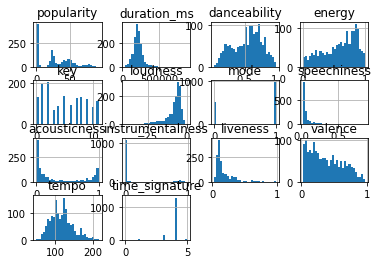

In [8]:
df.hist(bins=30)